In [61]:
%pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [62]:
%pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [63]:
# Import required libraries
import os
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Input, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import keras_tuner as kt
import pmdarima as pm
import datetime
import itertools

from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [64]:
np.random.seed(314)

In [65]:
# %%
def load_process_data(ticker, start_date, end_date, data_dir='stock_data',
                     dealNaN=True, drop_NaN=True, split_by_ratio=False,
                     split_by_date=False, split_by_randomly=True,
                     split_date=None, scale=True, test_size=0.2):
    """Load and process stock data with various options for handling NaN and splitting"""
    feature_columns = ["Open", "High", "Low", "Close", "Adj Close"]

    # Create data directory if it doesn't exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    # Create file path for stock price data
    file_path = os.path.join(data_dir, f'{ticker}_{start_date}_{end_date}.csv')

    # Load or Download the data
    if os.path.exists(file_path):
        print(f"Loading the data from {file_path}")
        data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    else:
        print(f"Loading data {ticker} from Yahoo finance")
        data = yf.download(ticker, start_date, end_date)
        data.to_csv(file_path)
        print(f"Data saved to {file_path}")

    result = {'data': data.copy()}
    print(f"Data Samples {len(data)}")

    # Handle NaN values
    if dealNaN:
        print("NaN values before handling")
        print(data.isna().sum())
        if drop_NaN:
            data.dropna(inplace=True)
        else:
            data.fillna(data.mean(), inplace=True)
        print("NaN values after handling")
        print(data.isna().sum())

    # Split data
    if split_by_ratio:
        print('Splitting by ratio')
        train_samples = int((1-test_size) * len(data))
        result['data_train'] = data[:train_samples]
        result['data_test'] = data[train_samples:]
    elif split_by_date:
        print('Splitting by date')
        split_date = pd.to_datetime(split_date)
        result['data_train'] = data[data.index <= split_date]
        result['data_test'] = data[data.index > split_date]
    elif split_by_randomly:
        print('Splitting randomly')
        result['data_train'], result['data_test'] = train_test_split(
            data, test_size=test_size, shuffle=True)

    print(f"Training samples: {len(result['data_train'])}")
    print(f"Test samples: {len(result['data_test'])}")

    # Scale data if requested
    if scale:
        scalers = {}
        scaled_data = pd.DataFrame(index=data.index)

        for column in feature_columns:
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_data[column] = scaler.fit_transform(
                data[column].values.reshape(-1, 1)).flatten()
            scalers[column] = scaler

        result['scaled_data'] = scaled_data

    return result, scalers

In [66]:
# Configuration parameters
TICKER = 'AAPL'
START_DATE = '2020-01-01'
END_DATE = '2023-01-01'
N_STEPS = 30


# %%
# Load and process data
result, scalers = load_process_data(
    ticker=TICKER,
    start_date=START_DATE,
    end_date=END_DATE,
    split_by_date=False,
    split_by_randomly=False,
    split_by_ratio=True,
    split_date='2021-06-01',
    scale=True
)

Loading the data from stock_data/AAPL_2020-01-01_2023-01-01.csv
Data Samples 756
NaN values before handling
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
NaN values after handling
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Splitting by ratio
Training samples: 604
Test samples: 152


In [67]:
target = result['data']['Close']
target

Date
2020-01-02     75.087502
2020-01-03     74.357498
2020-01-06     74.949997
2020-01-07     74.597504
2020-01-08     75.797501
                 ...    
2022-12-23    131.860001
2022-12-27    130.029999
2022-12-28    126.040001
2022-12-29    129.610001
2022-12-30    129.929993
Name: Close, Length: 756, dtype: float64

In [68]:
def plot_predict(test, predictions, title='Predicted v.s Actual Values'):
    plt.figure(figsize=(10, 6))
    plt.plot(test, label='Actual Values', color='Blue', linestyle='--')
    plt.plot(predictions, label='Predicted Values', color='red')
    
    plt.title(title)
    plt.xlabel('Observation Number')
    plt.ylabel('Values')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [69]:
# def parser(x):
#     return datetime.strptime('190'+x, '%Y-%m')
X = target.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

Test RMSE: 3.310


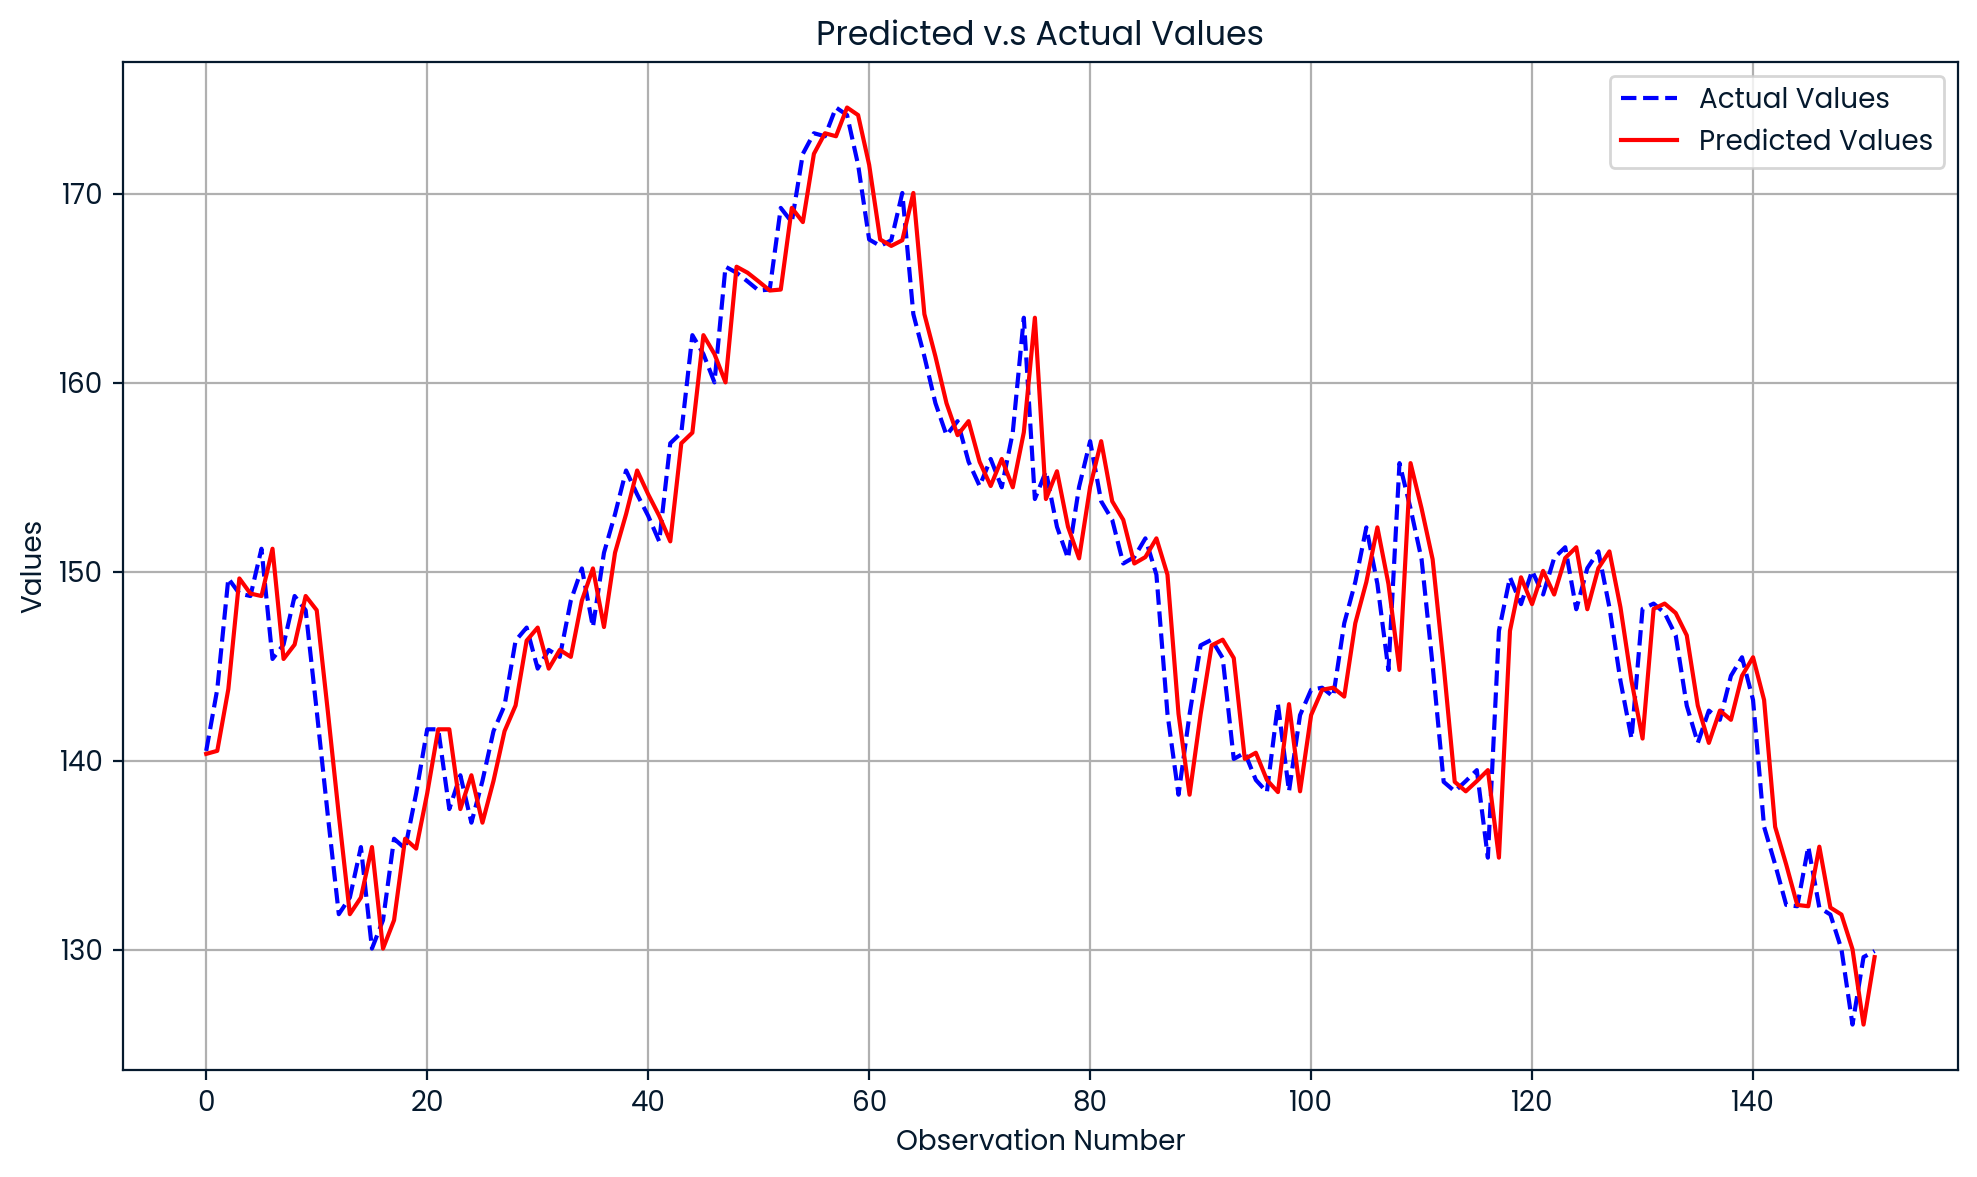

In [70]:
arima_predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

rmse = sqrt(mean_squared_error(test, arima_predictions))

print('Test RMSE: %.3f' % rmse)
plot_predict(test, arima_predictions)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75155D+00    |proj g|=  4.36003D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   7.474D-06   2.751D+00
  F =   2.7514771925812629     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76066D+00    |proj g|=  4.27630D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   7.013D-06   2.761D+00
  F =   2.7605874381140034     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77137D+00    |proj g|=  4.13676D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   6.613D-06   2.771D+00
  F =   2.7713022361205226     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77233D+00    |proj g|=  4.04811D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   6.463D-06   2.772D+00
  F =   2.7722652305409676     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77439D+00    |proj g|=  4.00086D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   6.191D-06   2.774D+00
  F =   2.7743251834969525     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77255D+00    |proj g|=  3.97046D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   6.276D-06   2.772D+00
  F =   2.7724846826989311     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77712D+00    |proj g|=  3.91063D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   6.030D-06   2.777D+00
  F =   2.7770615150145090     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   5.753D-06   2.781D+00
  F =   2.7809379612379530     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78269D+00    |proj g|=  3.84811D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78063D+00    |proj g|=  3.82512D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   5.689D-06   2.781D+00
  F =   2.7805683868180360     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   5.812D-06   2.783D+00
  F =   2.7834956354653855     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78344D+00    |proj g|=  3.77956D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78512D+00    |proj g|=  3.73917D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   5.696D-06   2.785D+00
  F =   2.7850585648256576     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78699D+00    |proj g|=  3.69852D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   5.351D-06   2.787D+00
  F =   2.7869365572460998     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79466D+00    |proj g|=  3.63753D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   5.051D-06   2.795D+00
  F =   2.7946000811521809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80107D+00    |proj g|=  3.58224D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   4.990D-06   2.801D+00
  F =   2.8010115796209969     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.8

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   4.752D-06   2.806D+00
  F =   2.8062357616050955     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80587D+00    |proj g|=  3.53379D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80477D+00    |proj g|=  3.51108D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   4.935D-06   2.805D+00
  F =   2.8047140235624317     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.8

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80501D+00    |proj g|=  3.48059D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   4.696D-06   2.805D+00
  F =   2.8049542793318474     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.8

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


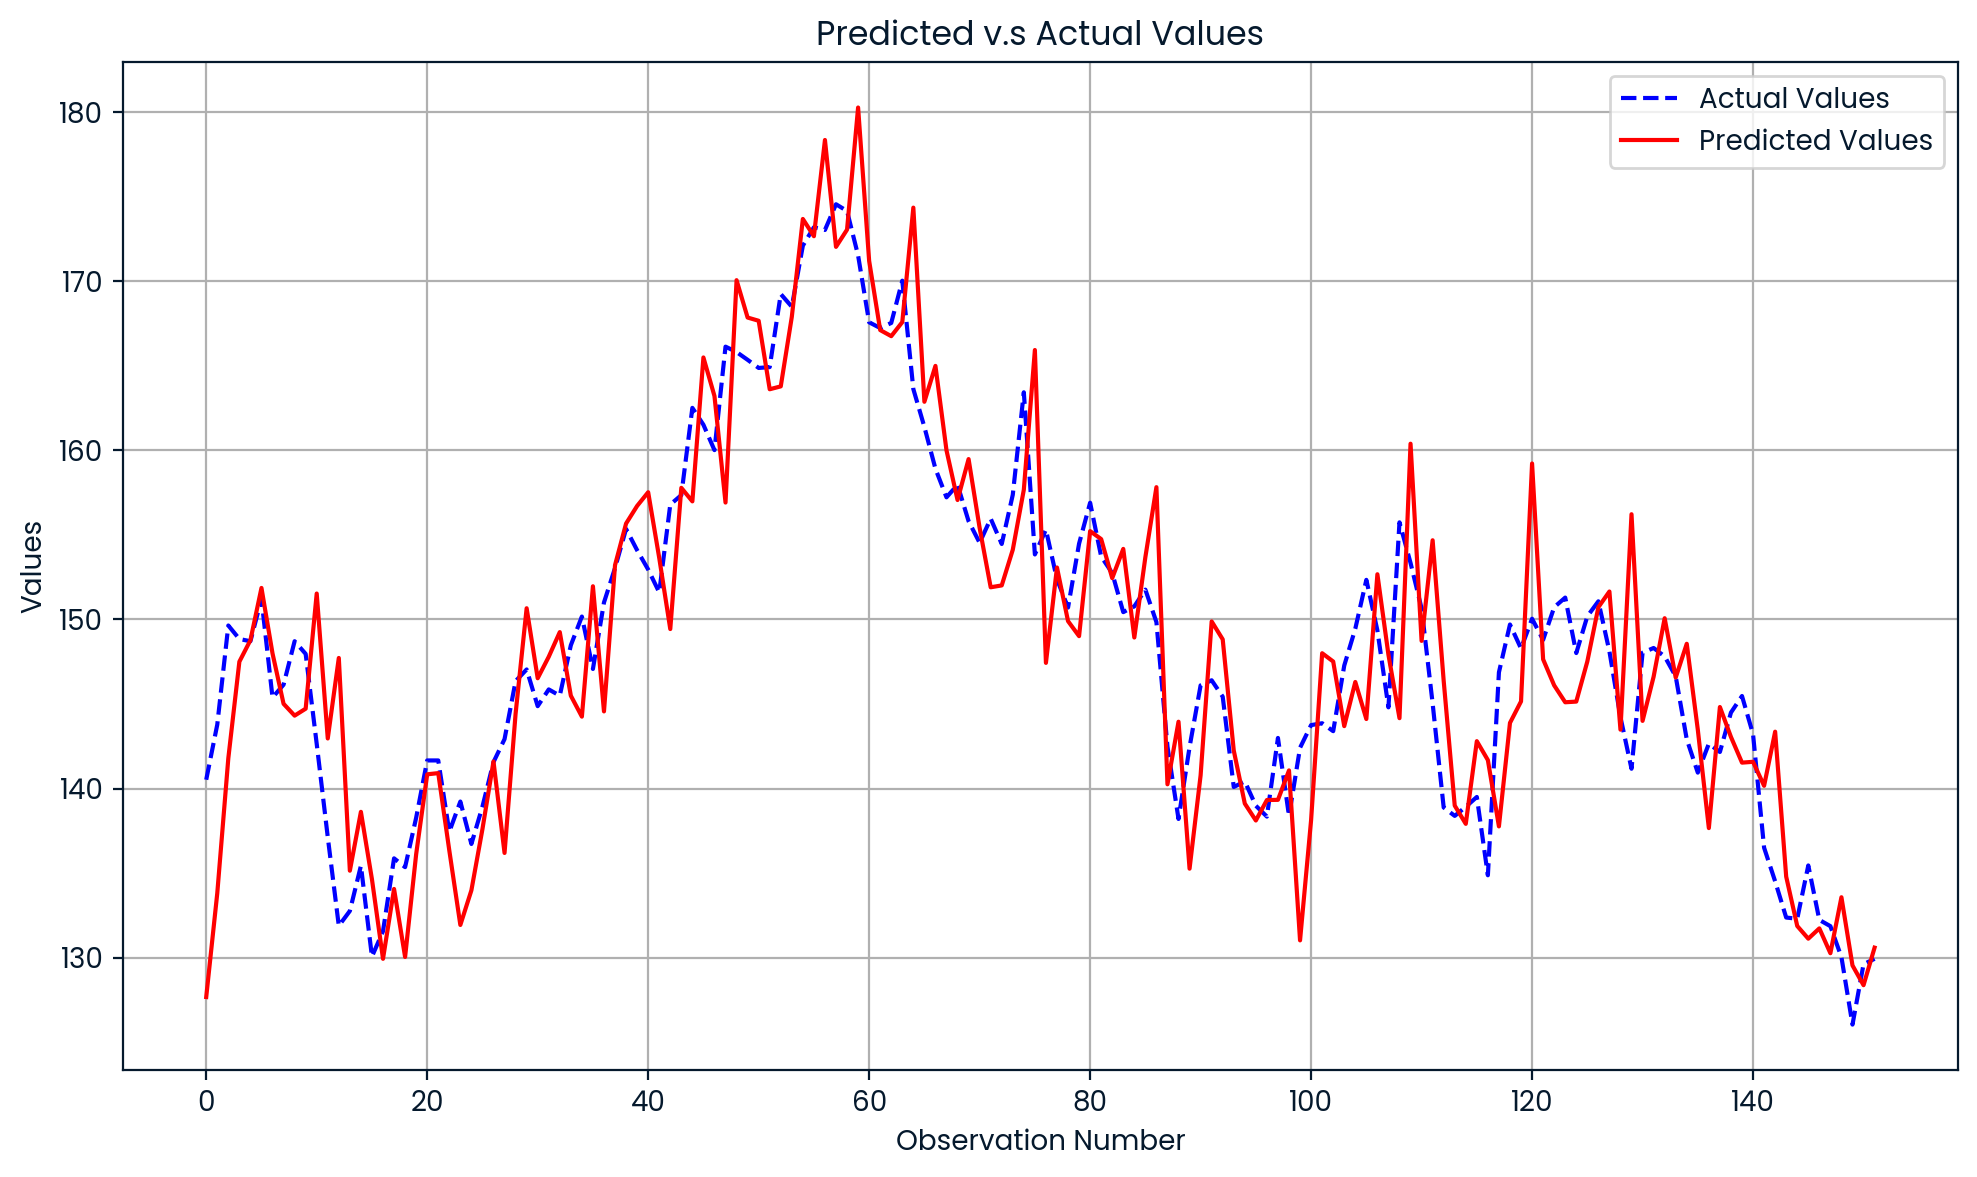

In [71]:
sarima_predictions = list()
for t in range(len(test)):
    model = SARIMAX(history, order=(0, 1, 0), seasonal_order=(0, 1, 0, 12))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    sarima_predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    
rmse = sqrt(mean_squared_error(test, sarima_predictions))
print('SARIMAX RMSE %.3f' %rmse)
plot_predict(test, sarima_predictions)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3302
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2453 
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1804 
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1290 
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0774 
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0463 
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0311 
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 0.0244
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0223 
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 0.0213
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 0.0198
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.0195
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0181 
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 0.0168
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 


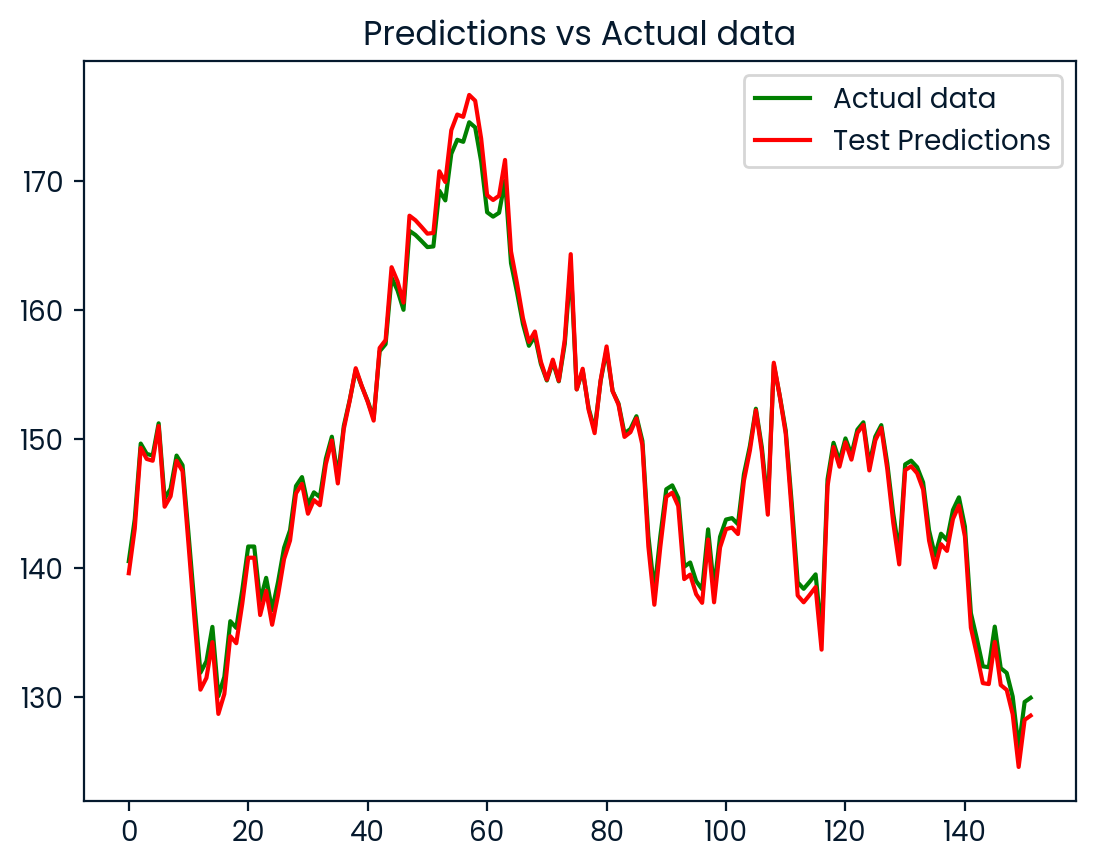

In [72]:
# Scale the data to (0,1) range
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train.reshape(-1, 1))
scaled_test = scaler.transform(test.reshape(-1, 1))

# Reshape data for LSTM (samples, 1 time step, 1 feature)
X_train = scaled_train.reshape(scaled_train.shape[0], 1, 1)
X_test = scaled_test.reshape(scaled_test.shape[0], 1, 1)
y_train = scaled_train
y_test = scaled_test

# Define the LSTM model
model = Sequential()
model.add(LSTM(25, return_sequences=False, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test)
test_rmse = sqrt(mean_squared_error(y_test, test_predict))
print('Test RMSE: %.3f' % test_rmse)

# Plot the predictions
plt.plot(range(len(test)), test, color='green', label='Actual data')
plt.plot(range(len(test_predict)), test_predict, color='red', label='Test Predictions')
plt.title('Predictions vs Actual data')
plt.legend()
plt.show()

In [73]:
lstm_result = [float(x) for x in test_predict]
arima_predictions = np.array(arima_predictions)
sarima_predictions = np.array(sarima_predictions)
lstm_result = np.array(test_predict).flatten()

# Simple Averaging Ensemble
ensemble_predictions = (arima_predictions + sarima_predictions + lstm_result) / 3

Ensemble Test RMSE: 2.531


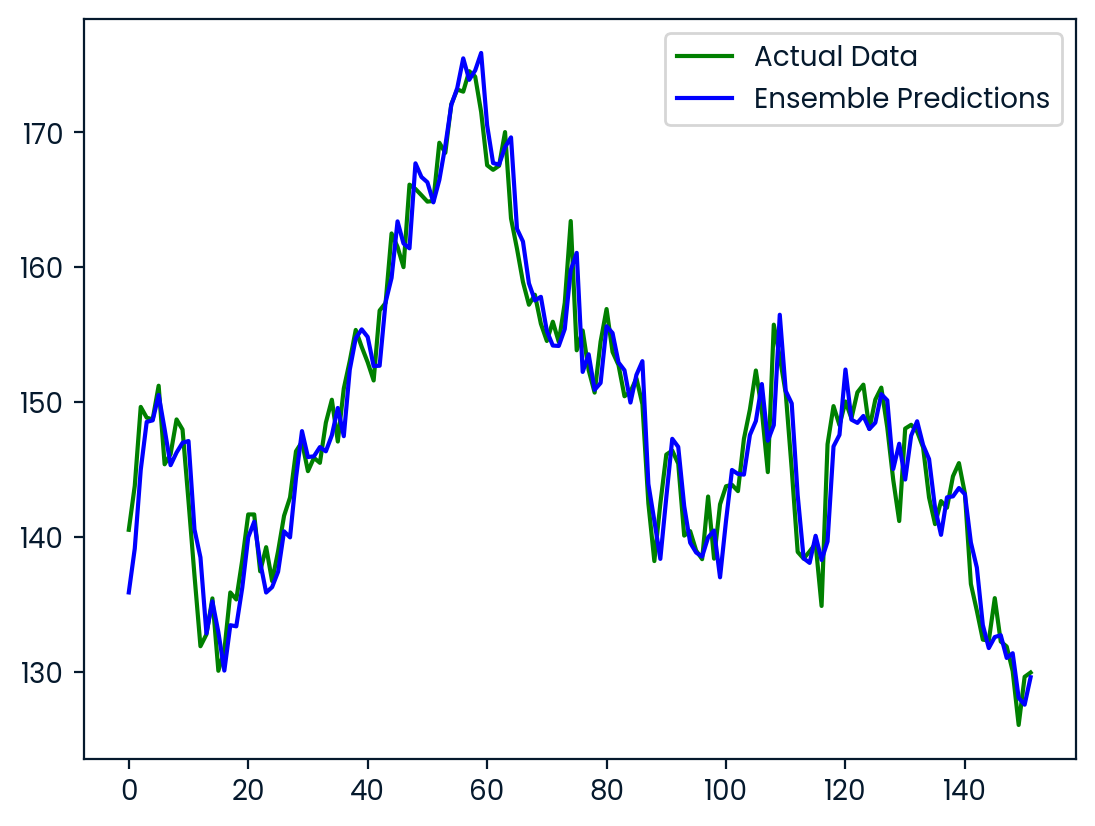

In [74]:
# Evaludate the Ensemble Predictions
ensemble_rmse = sqrt(mean_squared_error(y_test, ensemble_predictions))
print(f'Ensemble Test RMSE: {ensemble_rmse:.3f}')

plt.plot(range(len(y_test)), y_test, label='Actual Data', color='green')
plt.plot(range(len(ensemble_predictions)), ensemble_predictions, label='Ensemble Predictions', color='blue')
plt.legend()
plt.show()

Weighted Ensemble Test RMSE: 1.346


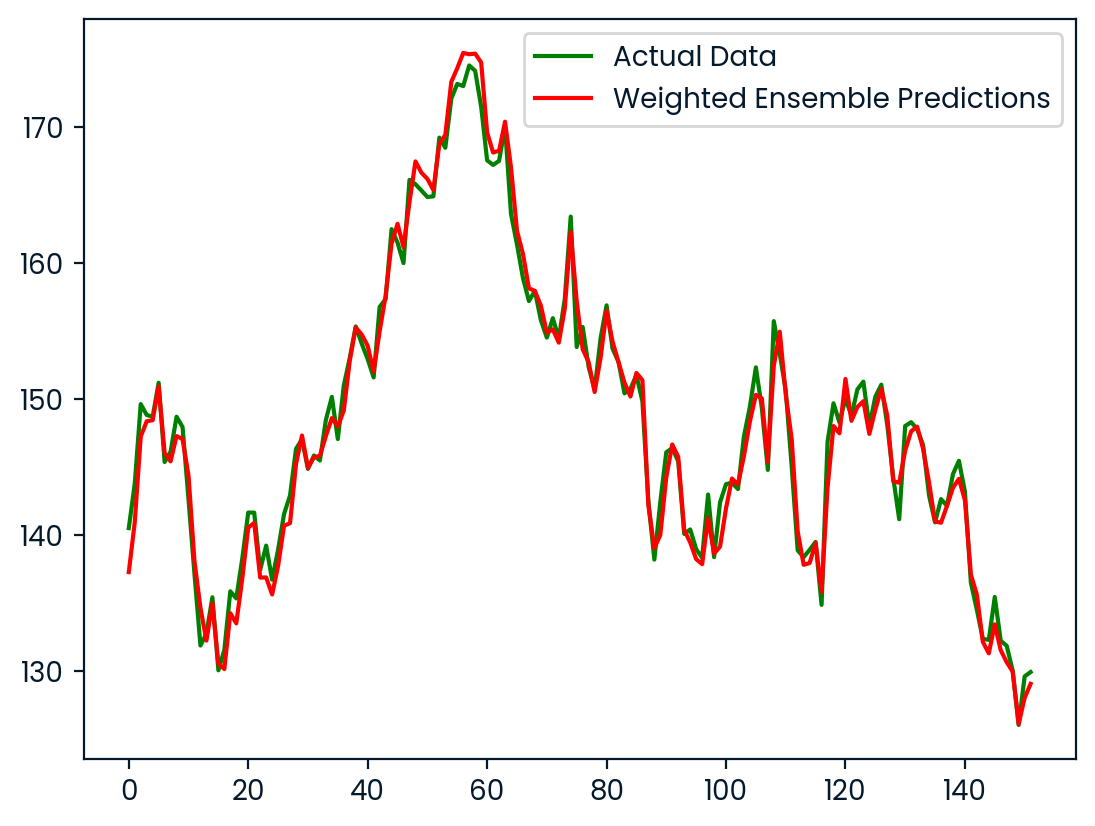

In [75]:
# Define the weights based on model performance
# Higher weight to models with better performance (lower RMSE)
arima_weight = 0.1
sarima_weight = 0.2
lstm_weight = 0.7

# Weighted Averaging Ensemble
ensemble_predictions_weighted = (arima_weight * arima_predictions + sarima_weight * sarima_predictions + lstm_weight * lstm_result)

# print(f'ARIMA Predictions Weighted: {arima_predictions}')
# print(f'SARIMA Predictions: {sarima_predictions}')
# print(f'LSTM Result: {lstm_result}')
# print(f'Ensemble Predictions Weighted: {ensemble_predictions_weighted}')

# Evaluate the Weighted Ensemble Predictions
ensemble_rmse_weighted = sqrt(mean_squared_error(y_test, ensemble_predictions_weighted))
print(f'Weighted Ensemble Test RMSE: {ensemble_rmse_weighted:.3f}')

# Plot the Weighted Ensemble Predictions vs Actual
plt.plot(range(len(y_test)), y_test, label='Actual Data', color='green')
plt.plot(range(len(ensemble_predictions_weighted)), ensemble_predictions_weighted, label='Weighted Ensemble Predictions', color='red')
plt.legend()
plt.show()

In [76]:
def create_sequences(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1))
# Reshape target to 2D array
scaled_data = scaler.fit_transform(target.values.reshape(-1, 1))

X, y = create_sequences(scaled_data, N_STEPS)
X = X.reshape((X.shape[0], X.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.shape, X_test.shape

((580, 30, 1), (145, 30, 1))

In [77]:
def evaluate_model(y_test, y_pred):
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    rmse = sqrt(mean_squared_error(y_test, y_pred_rescaled))
    print(f'RMSE: {rmse}')
    return rmse, y_pred_rescaled

y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

In [78]:
# Random Forest
# Flatten the data for Random Forest
X_train_rf = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test_rf = X_test.reshape((X_test.shape[0], X_test.shape[1]))

# Loop over different hyperparameters manually
n_estimators_list = [100, 200, 300]
max_depth_list = [10, 20, 30]

best_rmse_rf = float('inf') # unbounded upper value for comparison
best_params = {}

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        # Train Random Forest with different hyperparameters
        rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf_model.fit(X_train_rf, y_train)
        rf_predictions = rf_model.predict(X_test_rf)
        rf_rmse = sqrt(mean_squared_error(y_test, rf_predictions))
        print(f'n_estimators: {n_estimators}, max_depth: {max_depth}, RMSE: {rf_rmse}')
        if rf_rmse < best_rmse_rf:
            best_rmse_rf = rf_rmse
            best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}
    
print(f'Best RF Hyperparameters: {best_params}, Best RMSE: {best_rmse_rf}')

n_estimators: 100, max_depth: 10, RMSE: 0.02863176822819307
n_estimators: 100, max_depth: 20, RMSE: 0.028526955152866386
n_estimators: 100, max_depth: 30, RMSE: 0.028526955152866386
n_estimators: 200, max_depth: 10, RMSE: 0.02861106383896893
n_estimators: 200, max_depth: 20, RMSE: 0.028490345180782955
n_estimators: 200, max_depth: 30, RMSE: 0.028490345180782955
n_estimators: 300, max_depth: 10, RMSE: 0.02871678504778227
n_estimators: 300, max_depth: 20, RMSE: 0.028580411941899565
n_estimators: 300, max_depth: 30, RMSE: 0.028580411941899565
Best RF Hyperparameters: {'n_estimators': 200, 'max_depth': 20}, Best RMSE: 0.028490345180782955


RMSE: 3.587432917577353


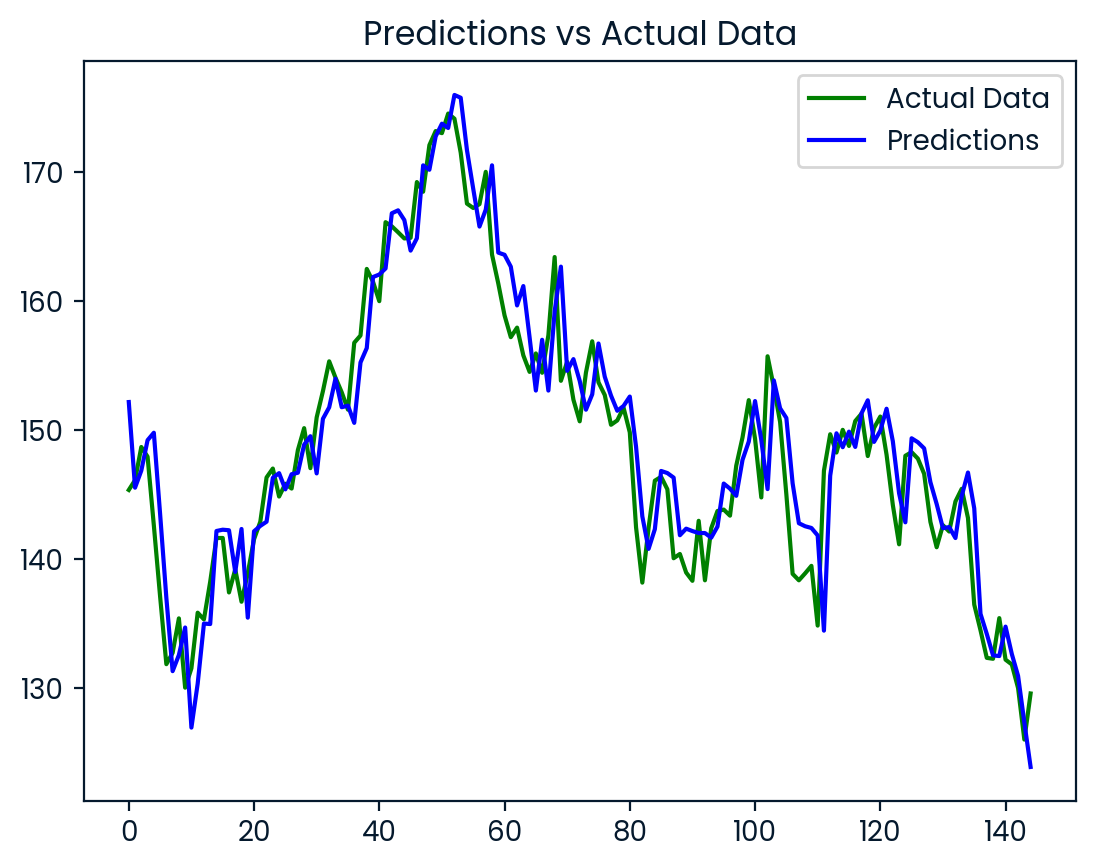

In [79]:
best_rf_model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
best_rf_model.fit(X_train_rf, y_train)

best_rf_predictions = best_rf_model.predict(X_test_rf)
best_rf_rmse, best_rf_predictions_rescaled = evaluate_model(y_test_rescaled, best_rf_predictions)

# Plot Actual vs Predictions
plt.plot(y_test_rescaled, label='Actual Data', color='green')
plt.plot(best_rf_predictions_rescaled, label='Predictions', color='blue')
plt.title('Predictions vs Actual Data')
plt.legend()
plt.show()

In [80]:
# Define the model-building function for Keras Tuner
def build_lstm_model(hp):
    model = Sequential()
    # Tune the number of units
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), input_shape=(N_STEPS, 1))) # 4 units
    model.add(Dense(1))
    
    # Tune the learning rate
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), loss='mean_squared_error') # 2 optimizer
    
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10, # 4 units, 2 optimizers = 8 trials, if trails > max trails, stop the search above the max trails
    executions_per_trial=1,
    directory='tuner_results',
    project_name='lstm_tuning'
)

# Run the search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

# Get the optimal hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
print(f'Best Hyperparameters: {best_hp.values}')

Reloading Tuner from tuner_results/lstm_tuning/tuner0.json
Best Hyperparameters: {'units': 150, 'optimizer': 'rmsprop'}


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0925 - val_loss: 0.0355
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0121 - val_loss: 0.0042
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0083 - val_loss: 0.0423
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0083 - val_loss: 0.0109
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0028 - val_loss: 0.0526
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0081 - val_loss: 0.0021
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0025 - val_loss: 0.0113
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0024 - val_loss: 0.0055
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0

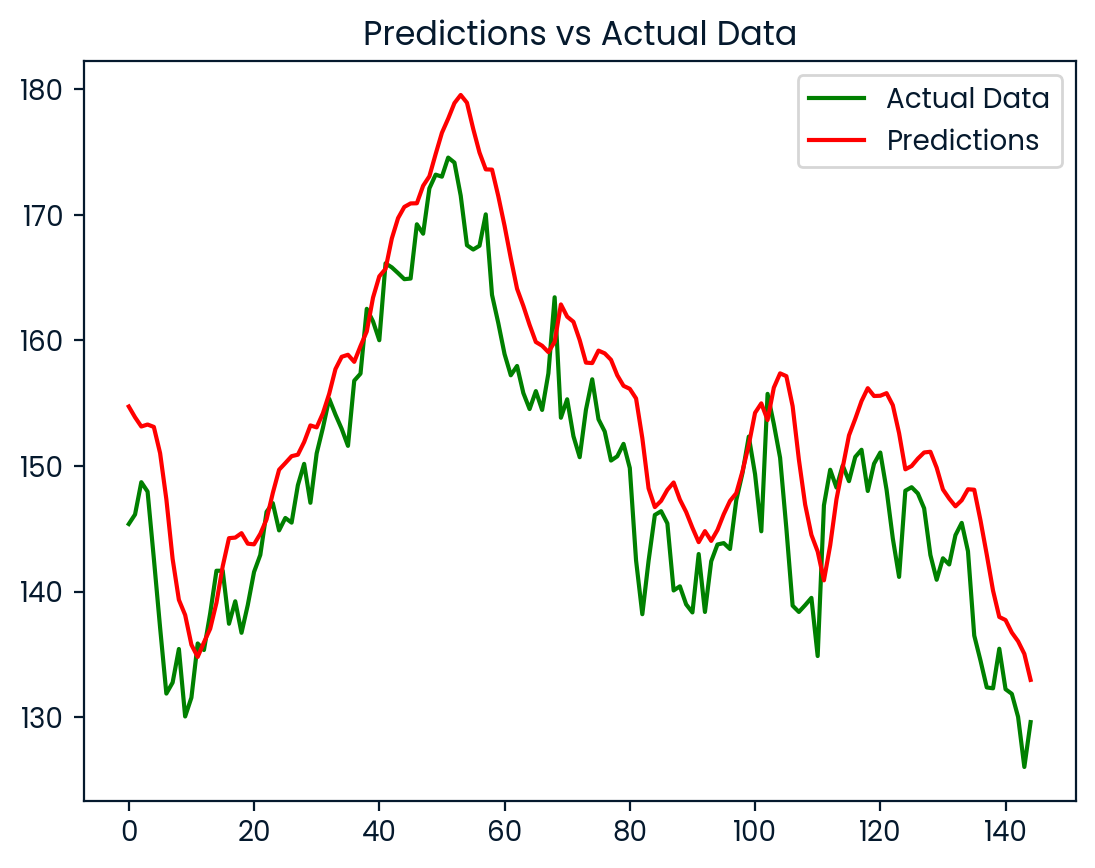

In [81]:
# Best hyperparameters from the tunner
best_units = 150
best_optimizer = 'rmsprop'

best_lstm_model = Sequential()
best_lstm_model.add(LSTM(best_units, input_shape=(N_STEPS, 1)))
best_lstm_model.add(Dense(1))
best_lstm_model.compile(optimizer=best_optimizer, loss='mean_squared_error')
best_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))
best_lstm_predictions = best_lstm_model.predict(X_test)

# Evaluate the final model
best_lstm_rmse, best_lstm_predictions_rescaled = evaluate_model(y_test_rescaled, best_lstm_predictions)

# Plot Actual and LSTM predictions
plt.plot(y_test_rescaled, label='Actual Data', color='green')
plt.plot(best_lstm_predictions_rescaled, label='Predictions', color='red')
plt.title('Predictions vs Actual Data')
plt.legend()

In [82]:
# GRU
# Define the model building function for Keras Tuner
def build_gru_model(hp):
    model = Sequential()
    # Tune the number of units
    model.add(GRU(units=hp.Int('units', min_value=50, max_value=200, step=50), input_shape=(N_STEPS, 1)))
    model.add(Dense(1))
    
    # Tuen the learning rate or optimizer
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), loss='mean_squared_error')
    return model

# Initialise the tuner
tuner_gru = kt.RandomSearch(
    build_gru_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results_gru',
    project_name='gru_tuning'
)

# Run the search
tuner_gru.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

# Get teh optimal hyperparameters
best_hp_gru = tuner_gru.get_best_hyperparameters()[0]
print(f'Best GRU Hyperparameters:: {best_hp_gru.values}')

Reloading Tuner from tuner_results_gru/gru_tuning/tuner0.json
Best GRU Hyperparameters:: {'units': 50, 'optimizer': 'adam'}


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2315 - val_loss: 0.0023
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0136 - val_loss: 0.0045
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0064 - val_loss: 0.0018
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.6213e-04 - val_loss: 0.0012
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7502e-04 - val_loss: 0.0012
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.8054e-04 - val_loss: 0.0012
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.1195e-04 - val_loss: 0.0012
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

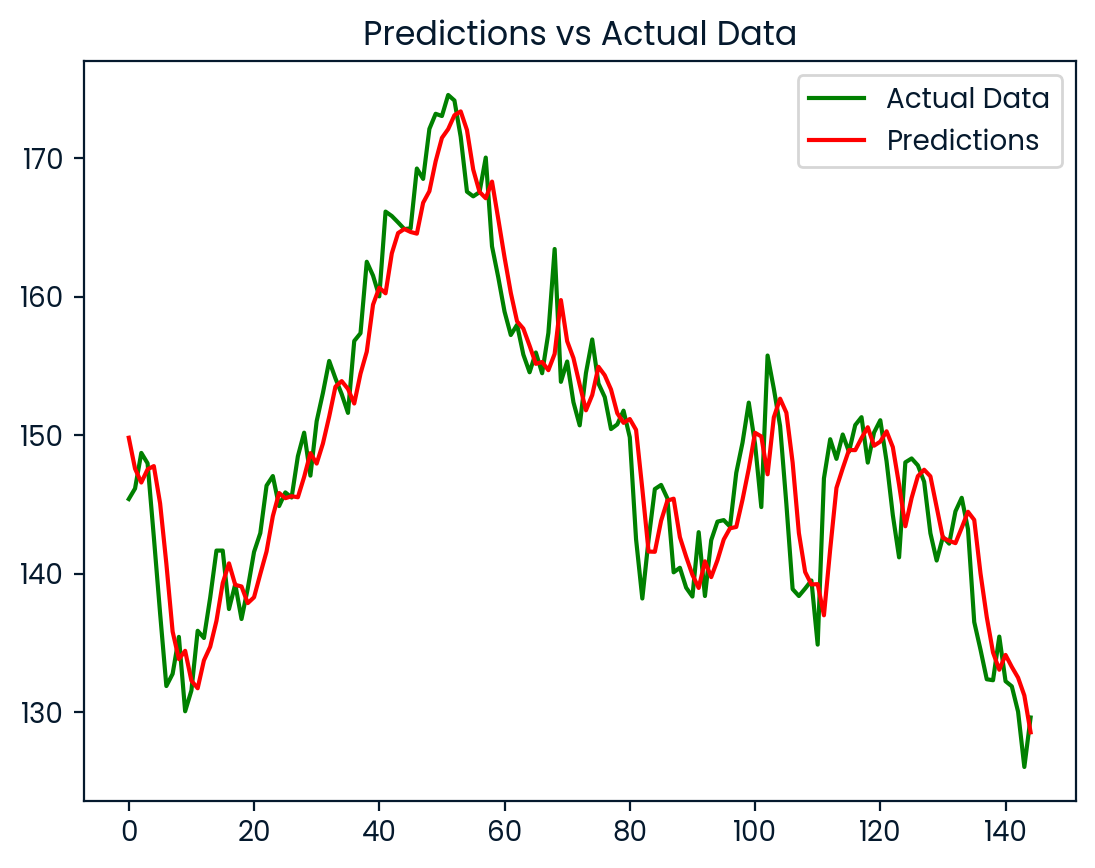

In [83]:
# Best hyperparameters from the tuner
best_units_gru = 50
best_optimizer_gru = 'adam'

best_gru_model = Sequential()
best_gru_model.add(GRU(best_units_gru, input_shape=(N_STEPS, 1)))
best_gru_model.add(Dense(1))
best_gru_model.compile(optimizer=best_optimizer_gru, loss='mean_squared_error')
best_gru_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

best_gru_predictions = best_gru_model.predict(X_test)

# Evaluate the final model
best_gru_rmse, best_gru_predictions_rescaled = evaluate_model(y_test_rescaled, best_gru_predictions)

# Plot Actual vs GRU Predictions
plt.plot(y_test_rescaled, label='Actual Data', color='green')
plt.plot(best_gru_predictions_rescaled, label='Predictions', color='red')
plt.title('Predictions vs Actual Data')
plt.legend()

In [84]:
# RNN
# Define the model building function for Keras Tuner
def build_rnn_model(hp):
    model = Sequential()
    # Tune the number of units
    model.add(SimpleRNN(units=hp.Int('units', min_value=50, max_value=200, step=50), input_shape=(N_STEPS, 1)))
    model.add(Dense(1))
    
    # Tune the learning rate or optimizer
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), loss='mean_squared_error')
    return model

# Initialise the tuner for RNN
tuner_rnn = kt.RandomSearch(
    build_rnn_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results_rnn',
    project_name='rnn_tuning'
)

# Run the search
tuner_rnn.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

# Get the optimal hyperparameters
best_hp_rnn = tuner_rnn.get_best_hyperparameters()[0]
print(f'Best RNN Hyperparameters: {best_hp_rnn.values}')

Reloading Tuner from tuner_results_rnn/rnn_tuning/tuner0.json
Best RNN Hyperparameters: {'units': 150, 'optimizer': 'rmsprop'}


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3078 - val_loss: 0.0102
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0136 - val_loss: 0.0030
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0189 - val_loss: 0.0043
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - val_loss: 0.1133
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0263 - val_loss: 0.0207
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - val_loss: 0.0014
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - val_loss: 0.0012
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_l

[]

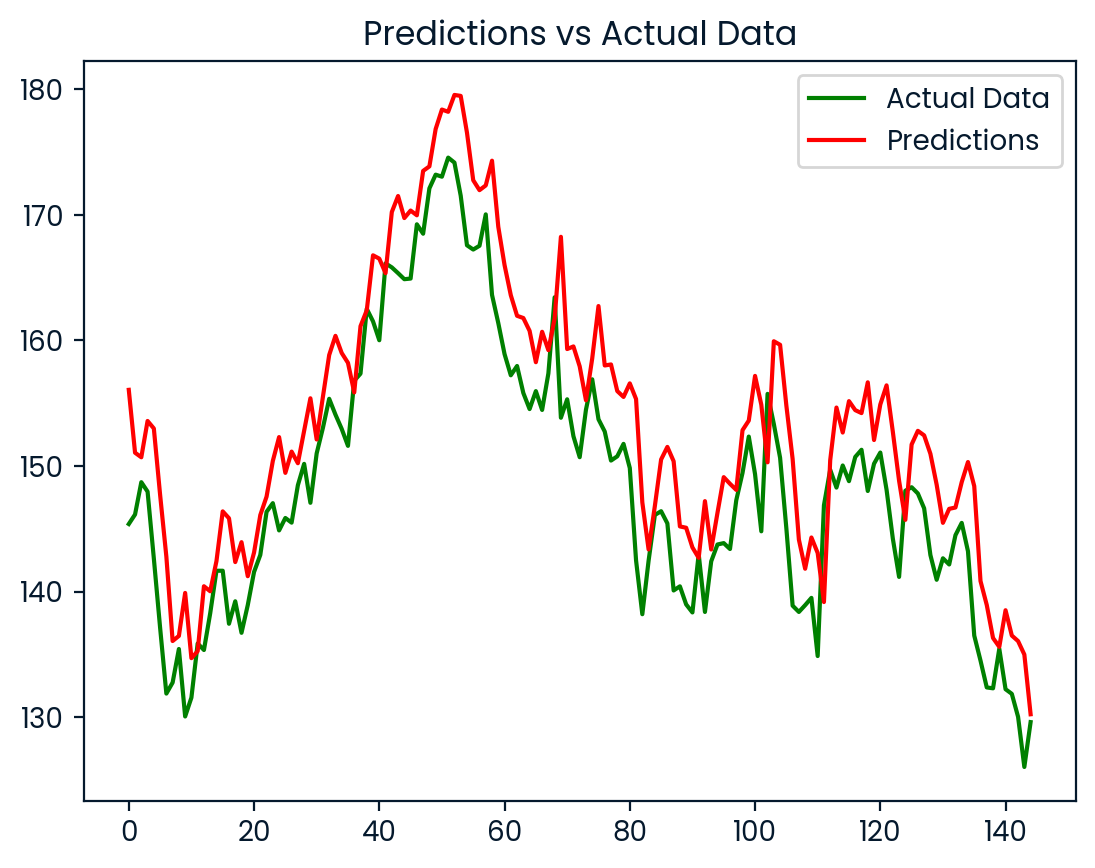

In [85]:
# Best hyperparameters from the tuner
best_units_rnn = 150
best_optimizer_rnn = 'rmsprop'

# Define the final RNN model with the best hyperparameters
best_rnn_model = Sequential()
best_rnn_model.add(SimpleRNN(best_units_rnn, input_shape=(N_STEPS, 1)))
best_rnn_model.add(Dense(1))
best_rnn_model.compile(optimizer=best_optimizer_rnn, loss='mean_squared_error')
best_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

best_rnn_predictions = best_rnn_model.predict(X_test)
best_rnn_rmse, best_rnn_predictions_rescaled = evaluate_model(y_test_rescaled, best_rnn_predictions)

# Plot Actual vs LSTM Predictions
plt.plot(y_test_rescaled, label='Actual Data', color='green')
plt.plot(best_rnn_predictions_rescaled, label='Predictions', color='red')
plt.title('Predictions vs Actual Data')
plt.legend()
plt.plot()

In [86]:
best_lstm = np.array(best_lstm_predictions_rescaled).flatten()
best_gru = np.array(best_gru_predictions_rescaled).flatten()
best_rnn = np.array(best_rnn_predictions_rescaled).flatten()
best_rf = np.array(best_rf_predictions_rescaled).flatten()

In [87]:
def evaluate_model(y_test, y_pred):
    #y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {rmse}')
    return rmse, y_pred

y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

RMSE: 4.363773460879436


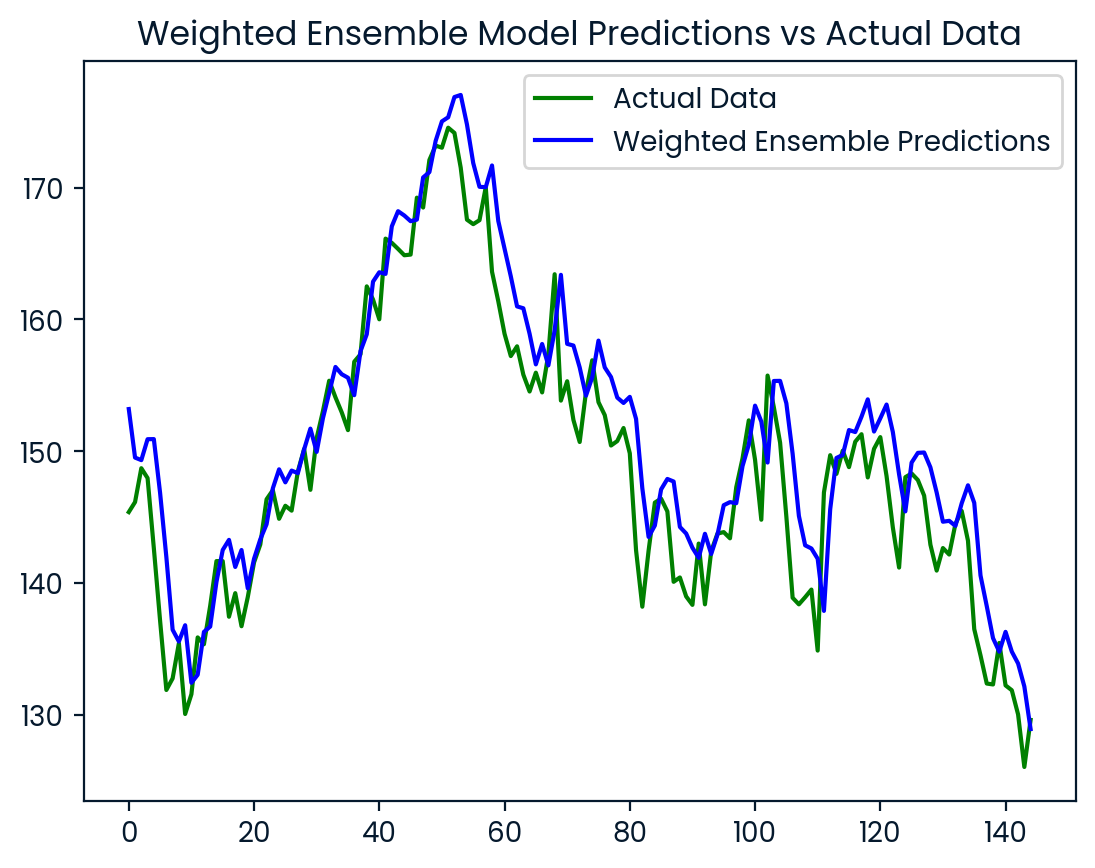

In [88]:
# Simple Averaging Ensemble (take the mean of the four models)
ensemble_predictions = (best_rnn + best_rf + best_gru + best_lstm) / 4

# Evaludate the Weighted Ensemble Predictions
ensemble_rmse_avg, ensemble_predictions_rescaled = evaluate_model(y_test_rescaled, ensemble_predictions)

# Plot the Weighted Predictions vs Actual
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual Data', color='green')
plt.plot(range(len(ensemble_predictions_rescaled)), ensemble_predictions_rescaled, label='Weighted Ensemble Predictions', color='blue')
plt.title('Weighted Ensemble Model Predictions vs Actual Data')
plt.legend()
plt.show()

In [89]:
rmse = [best_rf_rmse, best_lstm_rmse, best_gru_rmse, best_rnn_rmse]
rmse

[3.587432917577353, 6.438892945186215, 3.6293265114165125, 5.964679381333889]

In [90]:
rmse = np.array(rmse)
inverse_rmse = 1 / rmse
weights = inverse_rmse / np.sum(inverse_rmse)
rf_weight, lstm_weight, gru_weight, rnn_weight = weights

RMSE: 4.011719536922227


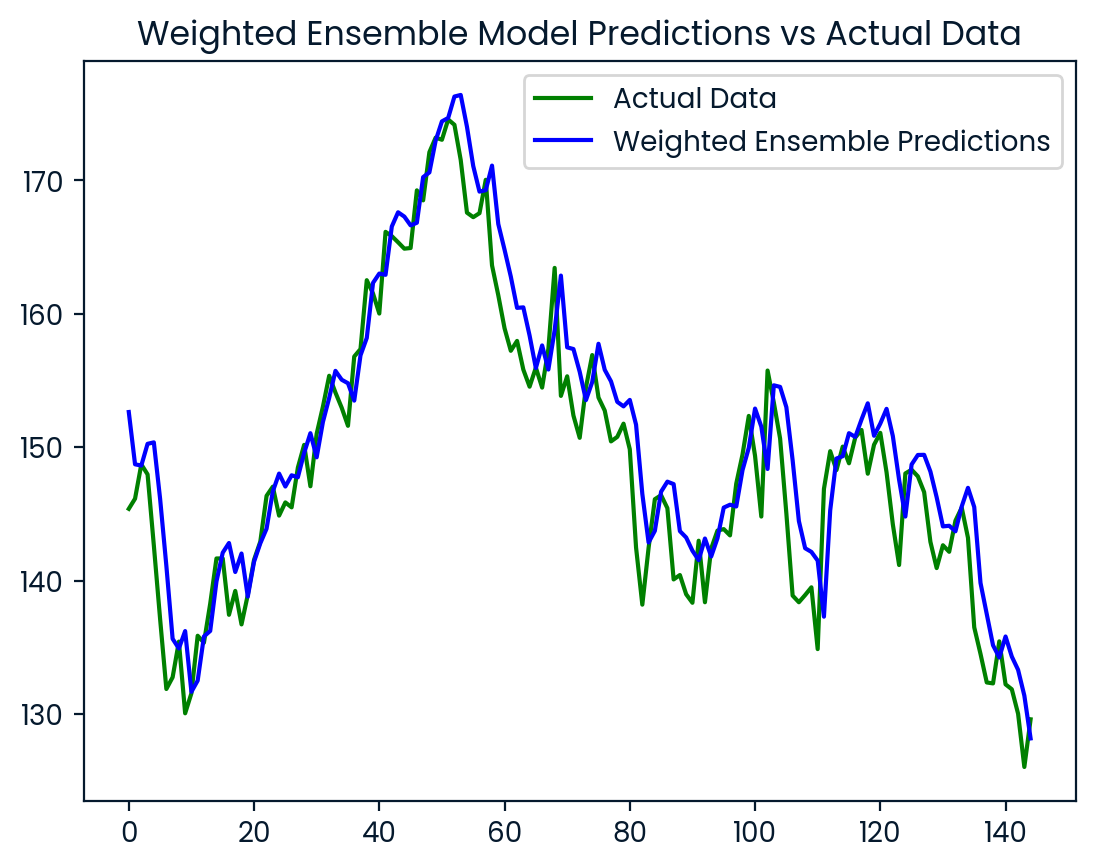

In [91]:
# Weighted Averaging Ensemble
ensemble_predictions_weighted = (best_lstm * lstm_weight + best_gru * gru_weight + best_rnn * rnn_weight + best_rf * rf_weight)

# Evaludate the Weighted Ensemble Predictions
ensemble_rmse_weighted, ensemble_prediction_rescaled = evaluate_model(y_test_rescaled, ensemble_predictions_weighted)

# Plot the weighted Ensemble Predicitons vs Actual
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual Data', color='green')
plt.plot(range(len(ensemble_prediction_rescaled)), ensemble_prediction_rescaled, label='Weighted Ensemble Predictions', color='blue')
plt.title('Weighted Ensemble Model Predictions vs Actual Data')
plt.legend()
plt.show()